In [1]:
# %pip install --quiet --upgrade pip 
# %pip install numpy --quiet
# %pip install Pandas --quiet
# %pip install sklearn --quiet
# %pip install ipywidgets --quiet

# Horse Racing Results Predictor using Linear regression #

Predict `TodaysRaceCard.csv` using simple linear regression techniques by determining predicted **speed** of a horse in a given race based on its previous performance. 

Data used here is derived from the features extracted by the [Feature Analysis](https://github.com/LeeSanderson/RacingData/blob/main/Data/FeatureAnalysis.ipynb) notebook.

## Build the model ##

In [2]:
import numpy as np
import pandas as pd
import math
from abc import ABC, abstractmethod
from datetime import datetime, date

In [3]:
races = pd.read_csv("Race_Features.csv")
races['Off'] =  pd.to_datetime(races['Off'], format='%Y-%m-%d %H:%M:%S')
races.columns

Index(['RaceId', 'CourseId', 'RaceType', 'Off', 'DecimalOdds',
       'OfficialRating', 'RacingPostRating', 'TopSpeedRating',
       'DistanceInMeters', 'Going', 'Surface', 'HorseId', 'HorseName',
       'JockeyId', 'JockeyName', 'Age', 'HeadGear', 'RaceCardNumber',
       'StallNumber', 'WeightInPounds', 'FinishingPosition',
       'OverallBeatenDistance', 'RaceTimeInSeconds', 'Wins',
       'Surface_AllWeather', 'Surface_Dirt', 'Surface_Turf', 'Going_Firm',
       'Going_Good', 'Going_Good_To_Firm', 'Going_Good_To_Soft', 'Going_Heavy',
       'Going_Soft', 'RaceType_Flat', 'RaceType_Hurdle', 'RaceType_Other',
       'RaceType_SteepleChase', 'Speed', 'HorseCount', 'KnownHorseAndJockey',
       'NumberOfPriorRaces', 'LastRaceGoing', 'LastRaceSurface',
       'LastRaceDistanceInMeters', 'LastRaceWeightInPounds', 'LastRaceSpeed',
       'DaysRested', 'LastRaceDecimalOdds', 'LastRaceOfficialRating',
       'LastRaceRacingPostRating', 'LastRaceTopSpeedRating',
       'LastRaceAvgRelFinishi

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

race_info = ['RaceId', 'CourseId', 'Off', 'HorseId', 'HorseName', 'HorseCount', 'JockeyId', 'JockeyName', 'DecimalOdds', 'Wins', 'FinishingPosition']
predictors = ([
    'DistanceInMeters', 
    'WeightInPounds', 
    'Surface_AllWeather', 'Surface_Dirt', 'Surface_Turf', 
    'Going_Firm', 'Going_Good', 'Going_Good_To_Firm', 'Going_Good_To_Soft', 'Going_Heavy', 'Going_Soft', 
    'RaceType_Flat', 'RaceType_Hurdle', 'RaceType_Other', 'RaceType_SteepleChase', 

    'LastRaceDistanceInMeters', 
    'LastRaceWeightInPounds', 
    'LastRaceSpeed',
    'DaysRested',
    'LastRaceAvgRelFinishingPosition', 
    'LastRaceSurface_AllWeather', 'LastRaceSurface_Dirt', 'LastRaceSurface_Turf', 
    'LastRaceGoing_Good', 'LastRaceGoing_Good_To_Soft', 'LastRaceGoing_Soft', 'LastRaceGoing_Good_To_Firm', 'LastRaceGoing_Firm', 'LastRaceGoing_Heavy', 
    'LastRaceRaceType_Other', 'LastRaceRaceType_Hurdle', 'LastRaceRaceType_SteepleChase', 'LastRaceRaceType_Flat', 
    
    'JockeyNumberOfPriorRaces',
    'DaysSinceJockeyLastRaced',     
    'JockeyWinPercentage',
    'JockeyTop3Percentage',
    'JockeyAvgRelFinishingPosition'
    ])
prediction = ["Speed"]

train = races[race_info + predictors + prediction].dropna().copy()

In [5]:
# Cap rested days
train.loc[train["DaysRested"] > 10, "DaysRested"] = 10
train.loc[train["DaysSinceJockeyLastRaced"] > 10, "DaysSinceJockeyLastRaced"] = 10

# Cap prior races
# train.loc[train["JockeyNumberOfPriorRaces"] > 400] = 400 (negative effect)

In [6]:
# Now that we've dropped any rows with na values, calculate which races in which we can predict the speed for all horses.
train = train.drop("PredictableHorseCount", axis=1, errors='ignore')
groups = train.groupby(['RaceId']).apply(lambda g: pd.Series({'PredictableHorseCount': g['RaceId'].count()}, index=['PredictableHorseCount']))
train = pd.merge(train, groups, how='left', on=['RaceId'])

# 50% of races have 11 horse, 25% have 8 or less, 14% have 6 or less, 9% have 5 or less. Fewer horses should be more predictable
all_races_count = len(races["RaceId"].unique())
all_predictable = train[(train["HorseCount"] == train["PredictableHorseCount"]) & (train["HorseCount"] <= 5)]["RaceId"].unique().tolist()
all_predictable_count = len(all_predictable)
print(f"Possible predictable races = {all_predictable_count} out of {all_races_count} ({all_predictable_count * 100 / all_races_count}%)")

Possible predictable races = 4039 out of 37987 (10.632584831652935%)


In [7]:
from sklearn.model_selection import train_test_split

_, test_race_ids = train_test_split(all_predictable, test_size=0.2, random_state = 42)

test = train[train["RaceId"].isin(test_race_ids)]
train = train[train["RaceId"].isin(test_race_ids) == False]

In [8]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create a pipeline that includes feature scaling and linear regression
model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2, interaction_only=False), Ridge())

In [9]:
inputs = train[predictors]
targets = train[prediction[0]].values

In [10]:
model.fit(inputs, targets)
test_inputs = test[predictors]
predictions = model.predict(test_inputs)

In [11]:
test_with_predictions = test.copy()
test_with_predictions["PredictedSpeed"] = predictions

In [12]:
test_with_predictions["PredictedRank"] = test_with_predictions.groupby("RaceId")["PredictedSpeed"].rank(method="dense", ascending=False)

In [14]:
correct_winners = test_with_predictions[(test_with_predictions["FinishingPosition"] == 1) & (test_with_predictions["PredictedRank"] == 1)]

correct_winners_count = len(correct_winners)
incorrect_winners_count = len(test_with_predictions[(test_with_predictions["FinishingPosition"] == 1) & (test_with_predictions["PredictedRank"] != 1)])

winnings = correct_winners["DecimalOdds"].sum()
win_percentage = 100.0 * correct_winners_count / (correct_winners_count + incorrect_winners_count)

print(f"Correct winners {correct_winners_count}, Incorrect winners {incorrect_winners_count}")
print(f"Win percentage {win_percentage}")
print(f"Winnings {winnings}, losses {incorrect_winners_count}, diff  {winnings - incorrect_winners_count}")

if win_percentage < 30:
    raise ValueError("Prediction rate too low")

Correct winners 273, Incorrect winners 537
Win percentage 33.7037037037037
Winnings 928.4868093018093, losses 537, diff  391.48680930180933


## Predictions ##

In [ ]:
todays_races = pd.read_csv("TodaysRaceCards.csv")
todays_races['Off'] =  pd.to_datetime(todays_races['Off'], format='%m/%d/%Y %H:%M:%S')
todays_races.columns

Index(['RaceId', 'RaceName', 'CourseId', 'CourseName', 'Off', 'RaceType',
       'Class', 'Pattern', 'RatingBand', 'AgeBand', 'SexRestriction',
       'Distance', 'DistanceInFurlongs', 'DistanceInMeters', 'DistanceInYards',
       'Going', 'Surface', 'HorseId', 'HorseName', 'JockeyId', 'JockeyName',
       'TrainerId', 'TrainerName', 'Age', 'HeadGear', 'RaceCardNumber',
       'StallNumber', 'Weight', 'WeightInPounds', 'FractionalOdds',
       'DecimalOdds', 'OfficialRating', 'RacingPostRating', 'TopSpeedRating'],
      dtype='object')

### Expand categorical variables

In [ ]:
surface_categories = ["Surface_AllWeather", "Surface_Dirt", "Surface_Turf"]
todays_races = todays_races.drop(surface_categories + ["Surface_Unknown"], axis=1, errors='ignore')
todays_races["SurfaceTemp"] = todays_races["Surface"]
todays_races = pd.get_dummies(todays_races, prefix="Surface", columns=["SurfaceTemp"], dtype=float)
todays_races = todays_races.drop("Surface_Unknown", axis=1, errors='ignore') # Drop unknown surface as only small number.
for surface in surface_categories:
    todays_races[surface] = todays_races.get(surface, 0.0)
todays_races[surface_categories].value_counts()

Surface_AllWeather  Surface_Dirt  Surface_Turf
0.0                 0.0           1.0             439
dtype: int64

In [ ]:
# Normalise going based on rules here: https://www.racingpost.com/guide-to-racing/what-is-the-going-ann7h6W6VB3b/
# Values should be: Firm, Good_To_Firm, Good, Good_To_Soft, Soft, Heavy
norm_map = ({
    "Good": "Good", 
    "Standard": "Good",
    "Soft": "Soft",
    "Good To Soft": "Good_To_Soft",
    "Good To Firm": "Good_To_Firm",
    "Heavy": "Heavy",
    "Good To Yielding": "Good_To_Soft",    
    "Yielding": "Good_To_Soft",
    "Standard To Slow": "Good_To_Soft",  
    "Very Soft": "Heavy",
    "Fast": "Firm",
    "Firm": "Firm",
    "Soft To Heavy": "Heavy",    
    "Yielding To Soft": "Soft",
    "Slow": "Soft",
    "Sloppy": "Heavy",
    "Muddy": "Heavy",
    "Frozen": "Heavy"
})

todays_races["NormGoing"] = todays_races["Going"].map(norm_map)

In [ ]:
going_categories  = ["Going_Good", "Going_Good_To_Soft", "Going_Soft", "Going_Good_To_Firm", "Going_Firm", "Going_Heavy"]
todays_races = todays_races.drop(going_categories, axis=1, errors='ignore')
todays_races = pd.get_dummies(todays_races, prefix="Going", columns=["NormGoing"], dtype=float)
for going in going_categories:
    todays_races[going] = todays_races.get(going, 0.0)

todays_races[going_categories].value_counts()

Going_Good  Going_Good_To_Soft  Going_Soft  Going_Good_To_Firm  Going_Firm  Going_Heavy
1.0         0.0                 0.0         0.0                 0.0         0.0            214
0.0         1.0                 0.0         0.0                 0.0         0.0            149
            0.0                 1.0         0.0                 0.0         0.0             76
dtype: int64

In [ ]:
race_type_categories = ["RaceType_Other", "RaceType_Hurdle", "RaceType_SteepleChase", "RaceType_Flat"]
todays_races = todays_races.drop(race_type_categories, axis=1, errors='ignore')
todays_races["RaceTypeTemp"] = todays_races["RaceType"]
todays_races = pd.get_dummies(todays_races, prefix="RaceType", columns=["RaceTypeTemp"], dtype=float)
for race_type in race_type_categories:
    todays_races[race_type] = todays_races.get(race_type, 0.0)

todays_races[race_type_categories].value_counts()

RaceType_Other  RaceType_Hurdle  RaceType_SteepleChase  RaceType_Flat
1.0             0.0              0.0                    0.0              309
0.0             1.0              0.0                    0.0               78
                0.0              1.0                    0.0               47
                                 0.0                    1.0                5
dtype: int64

### Load horse stats

In [ ]:
horse_stats = pd.read_csv("Horse_Stats.csv")
horse_stats['LastOff'] =  pd.to_datetime(horse_stats['LastOff'], format='%Y-%m-%d %H:%M:%S')
horse_stats.columns

Index(['HorseId', 'LastOff', 'LastRaceDistanceInMeters',
       'LastRaceWeightInPounds', 'LastRaceAvgRelFinishingPosition',
       'LastRaceSurface_AllWeather', 'LastRaceSurface_Dirt',
       'LastRaceSurface_Turf', 'LastRaceGoing_Firm', 'LastRaceGoing_Good',
       'LastRaceGoing_Good_To_Firm', 'LastRaceGoing_Good_To_Soft',
       'LastRaceGoing_Heavy', 'LastRaceGoing_Soft', 'LastRaceRaceType_Flat',
       'LastRaceRaceType_Hurdle', 'LastRaceRaceType_Other',
       'LastRaceRaceType_SteepleChase', 'LastRaceSpeed'],
      dtype='object')

In [ ]:
todays_races = pd.merge(todays_races, horse_stats, how="left", on=["HorseId"])

In [ ]:
today = np.datetime64(datetime.today())
one_day = np.timedelta64(1, 'D')
todays_races["DaysRested"] = np.ceil((today - todays_races["LastOff"]) / one_day)
todays_races.loc[todays_races["DaysRested"] > 10, "DaysRested"] = 10
todays_races = todays_races.drop("LastOff", axis=1, errors='ignore')

In [ ]:
groups = todays_races.groupby(['RaceId']).apply(lambda g: pd.Series({'HorseCount': g['RaceId'].count()}, index=['HorseCount']))
todays_races = pd.merge(todays_races, groups, how='left', on=['RaceId'])

### Load jockey stats

In [ ]:
jockey_stats = pd.read_csv("Jockey_Stats.csv")
jockey_stats['LastOff'] =  pd.to_datetime(jockey_stats['LastOff'], format='%Y-%m-%d %H:%M:%S')
jockey_stats.columns

Index(['JockeyId', 'LastOff', 'JockeyNumberOfPriorRaces',
       'JockeyWinPercentage', 'JockeyTop3Percentage',
       'JockeyAvgRelFinishingPosition'],
      dtype='object')

In [ ]:
todays_races = pd.merge(todays_races, jockey_stats, how="left", on=["JockeyId"])

In [ ]:
todays_races["DaysSinceJockeyLastRaced"] = np.ceil((today - todays_races["LastOff"]) / one_day)
todays_races.loc[todays_races["DaysSinceJockeyLastRaced"] > 10, "DaysSinceJockeyLastRaced"] = 10
todays_races = todays_races.drop("LastOff", axis=1, errors='ignore')

### Eliminate races that cannot be reliably predicted

array([[<AxesSubplot:title={'center':'HorseCount'}>]], dtype=object)

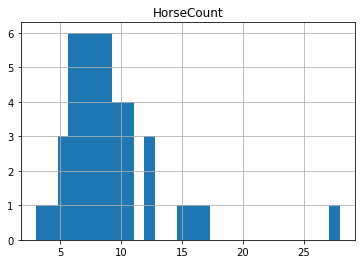

In [ ]:
race_info = ['RaceId', 'CourseId', 'CourseName', 'Off', 'HorseId', 'HorseName', 'HorseCount', 'JockeyId', 'JockeyName']

races_to_predict = todays_races[race_info + predictors].dropna().copy()

max_horses_in_race = races_to_predict["HorseCount"].max()
races_to_predict.groupby("RaceId").apply(lambda g: pd.Series({'HorseCount': g['RaceId'].count()}, index=['HorseCount'])).hist(bins=max_horses_in_race)

array([[<AxesSubplot:title={'center':'HorseCount'}>]], dtype=object)

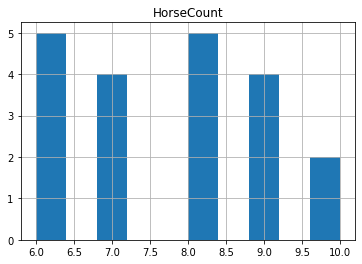

In [ ]:
if len(races_to_predict) > 0:
    # Now that we've dropped any rows with na values, calculate which races in which we can predict the speed for all horses.
    races_to_predict = races_to_predict.drop("PredictableHorseCount", axis=1, errors='ignore')
    groups = races_to_predict.groupby(['RaceId']).apply(lambda g: pd.Series({'PredictableHorseCount': g['RaceId'].count()}, index=['PredictableHorseCount']))
    races_to_predict = pd.merge(races_to_predict, groups, how='left', on=['RaceId'])
    races_to_predict = races_to_predict[(races_to_predict["HorseCount"] == races_to_predict["PredictableHorseCount"]) & (races_to_predict["HorseCount"] <= 10)]

max_horses_in_race = races_to_predict["HorseCount"].max()
races_to_predict.groupby("RaceId").apply(lambda g: pd.Series({'HorseCount': g['RaceId'].count()}, index=['HorseCount'])).hist(bins=max_horses_in_race)

In [ ]:
test_inputs = races_to_predict[predictors]
predictions = model.predict(test_inputs)
races_to_predict["PredictedSpeed"] = predictions

In [ ]:
races_to_predict["PredictedRank"] = races_to_predict.groupby("RaceId")["PredictedSpeed"].rank(method="dense", ascending=False)

In [ ]:
todays_predictions = (races_to_predict[races_to_predict["PredictedRank"] == 1]
    .sort_values(["CourseName", "Off"])
    [["RaceId", "CourseId", "CourseName", "Off", "HorseId", "HorseName"]])

todays_predictions.to_csv("TodaysPredictions.csv", index=False)

todays_predictions

,RaceId,CourseId,CourseName,Off,HorseId,HorseName
6,847768,6,Beverley,2023-09-20 13:50:00,5045863,Pete The Brief
36,847762,6,Beverley,2023-09-20 16:00:00,3526627,Mattice
48,847764,6,Beverley,2023-09-20 17:10:00,2801626,Dandy's Angel
60,850101,6,Beverley,2023-09-20 17:45:00,3781879,Brunello Breeze
301,850103,396,Happy Valley,2023-09-20 12:15:00,3855484,Classic Archi
319,850105,396,Happy Valley,2023-09-20 13:15:00,4804239,June Planet
351,850108,396,Happy Valley,2023-09-20 14:45:00,3729007,Up And Up
256,847895,27,Kelso,2023-09-20 15:30:00,3966616,Our Marty
266,847892,27,Kelso,2023-09-20 16:05:00,2855872,Fusain
276,850102,27,Kelso,2023-09-20 17:15:00,2654538,Darkest Day


In [ ]:
print(f"Generated predictions for {len(todays_predictions)} races")
print(todays_predictions[["CourseName", "Off", "HorseName"]].to_string(index=False))

Generated predictions for 20 races
  CourseName                 Off        HorseName
    Beverley 2023-09-20 13:50:00   Pete The Brief
    Beverley 2023-09-20 16:00:00          Mattice
    Beverley 2023-09-20 17:10:00    Dandy's Angel
    Beverley 2023-09-20 17:45:00  Brunello Breeze
Happy Valley 2023-09-20 12:15:00    Classic Archi
Happy Valley 2023-09-20 13:15:00      June Planet
Happy Valley 2023-09-20 14:45:00        Up And Up
       Kelso 2023-09-20 15:30:00        Our Marty
       Kelso 2023-09-20 16:05:00           Fusain
       Kelso 2023-09-20 17:15:00      Darkest Day
       Kelso 2023-09-20 17:50:00       Sebastopol
       Kelso 2023-09-20 18:25:00 Lights Are Green
    Listowel 2023-09-20 14:45:00        Bialystok
    Listowel 2023-09-20 15:50:00             Heia
     Sandown 2023-09-20 13:55:00      Exquisitely
     Sandown 2023-09-20 16:15:00    Eastern Charm
     Sandown 2023-09-20 16:50:00           Outgun
    Yarmouth 2023-09-20 14:05:00      Zina Colada
    Yarmouth 20